<font size=+3 color="#141774"><center><b>Titanic Competition: A Beginner-friendly Approach to Top 3% with Ensemble Learning 🛳️</b></center></font>

<img src="https://images.unsplash.com/photo-1542614370-156b709e78f8?ixlib=rb-1.2.1&ixid=eyJhcHBfaWQiOjEyMDd9&auto=format&fit=crop&w=1350&q=80" width = 400>
<center>Photo by Annie Spratt (Unsplash)</center>

# Introduction

Hello readers and welcome to my attempt at the [Titanic ML competition](https://www.kaggle.com/c/titanic) on Kaggle! In this notebook we will:

- Perform **Exploratory Data Analysis** (EDA) and gain insights on the factors that affected passenger survival,
- Perform **Feature Engineering** to create better features and improve our models,
- Built several **Machine Learning models** to predict whether a passenger survived the shipwreck.

I have included text to explain my reasoning/workflow and make this kernel as <font size=+0 color="#BF570F"><b>beginner friendly</b></font> as possible. I didn't go into much detail about Machine Learning concepts ('What is SVC?', 'what's k in k-Nearest Neighbors?' etc.) but you are welcome to ask me anything in the comments.

Please consider <font size=+0 color="red"><b>upvoting</b></font> if you found it useful! 🧐
    
<br>

**Table of Contents**

1. [Introduction](#Introduction)
2. [Libraries](#Libraries)
3. [Getting the Data](#Getting-the-Data)
4. [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
5. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
6. [Preparing Data](#Preparing-Data)
7. [Building Machine Learning Models](#Building-Machine-Learning-Models)
8. [Conclusions](#Conclusions)

In [3]:
# kaggle.json을 .kaggle폴더를 생성한 후에 그 폴더로 복사한다.
# 폴더를 생성
!mkdir -p ~/.kaggle
# 생성된 폴더로 복사
!cp kaggle.json ~/.kaggle

# 읽기/쓰기 권한을 준다.
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# 시스템 관리자 권한으로 /root/.kaggle/ 폴더에 파일이 복사됐는지 확인

!sudo ls -al ~/.kaggle

total 16
drwxr-xr-x 2 root root 4096 Aug 23 01:23 .
drwx------ 1 root root 4096 Aug 23 01:23 ..
-rw------- 1 root root   64 Aug 23 01:24 kaggle.json


In [6]:
# train.csv와 test.csv파일을 /content 폴더에 다운로드
!kaggle competitions download -c titanic

  0% 0.00/34.1k [00:00<?, ?B/s]
100% 34.1k/34.1k [00:00<00:00, 37.3MB/s]


# 환경설정 및 패키지 불러오기

We start by importing the necessary libraries and setting some parameters for the whole notebook (such as parameters for the plots, etc.). We will mainly use:

- Pandas for handling and analysing data,
- Seaborn and Matplotlib for data visualization, and
- Scikit-learn for building Machine Learning models.

In [12]:
# 향후 버전이 올라갈 때 변경될 사항 등을 알려주는 경고 메시지(warning message) 무시

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# 소수점 3째자리 미만을 지수로 표현
pd.set_option('display.precision', 3)

import matplotlib as mpl
import matplotlib.pyplot as plt

# 그래프를 더 높은 해상도로 출력한다.
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
sns.set_style('dark')

# 그래프를 그릴때 레이블, 타이틀, legend 폰트 크기 지정
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['axes.titlesize'] = 15
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['legend.fontsize'] = 12

# 데이터 전처리
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

# 머신러닝 알고리즘 패키지 가져오기
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
from xgboost import XGBClassifier

# 성능을 평가하기 위한 기준
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score

print ('Libraries Loaded!')

Libraries Loaded!


In [13]:
# 앞에서 pd.set_option('precision', 3)를 설정한 것을 확인해 보자.
pd.set_option('precision', 3)
pd.DataFrame({'x': [0.5], 'y': [0.3123456]})

OptionError: Pattern matched multiple keys

# 데이터셋 불러오기

In [14]:
# 타이타닉 폴더만들기

!mkdir -p titanic

In [15]:
# 압출 풀기

import zipfile
with zipfile.ZipFile('/content/titanic.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/titanic')


In [16]:
# 학습 데이터와 테스트 데이터 읽어오기

train_df = pd.read_csv('/content/titanic/train.csv')
test_df = pd.read_csv('/content/titanic/test.csv')

print (train_df.shape, test_df.shape)

(891, 12) (418, 11)


The training set is labeled, i.e. we know the outcome for each passenger, hence the difference in the number of columns.

We are going to merge the two dataframes into one. The new dataframe will have **NaN** in the 'Survived' column for instances of the test set:

In [17]:
# train data와 test data를 합쳐준다.
all_data = pd.concat([train_df, test_df])

In [18]:
all_data.shape

(1309, 12)

In [19]:
all_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


In [20]:
all_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
413,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.050,NaN,S
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S
416,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.050,NaN,S
417,1309,NaN,3,"Peter, Master. Michael J",male,NaN,1,1,2668,22.358,NaN,C


In [21]:
print ('Combined set: {} rows and {} columns'.format(all_data.shape[0], all_data.shape[1]))
print ('\nSurvived?: ')
all_data['Survived'].value_counts(dropna = False)

Combined set: 1309 rows and 12 columns

Survived?: 


,count
Survived,
0.0,549
NaN,418
1.0,342


# A Quick Look at our Data

In this stage, we will temporarily forget the test set and focus on the training set.

We can take a look at the top five rows of the training set using the `head()` method:

In [ ]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


The meaning of each attribute is the following:

- **PassengerId**: the ID given to each passenger,
- **Survived**: the target attribute (1 for passengers who survived, 0 for those who didn't),
- **Pclass**: Ticket class (1 = 1st, 2 = 2nd, 3 = 3rd class),
- **Name**, **Sex**, **Age**: self-explanatory,
- **SibSp**: Number of siblings & spouses aboard the Titanic,
- **Parch**: Number of parents & children aboard the Titanic,
- **Ticket**: Ticket number,
- **Fare**: Passenger fare (in pounds),
- **Cabin**: Passenger's cabin number, and
- **Embarked**: Port of Embarkation (C = Cherbourg, Q = Queenstown, S = Southampton).

'PassengerId' is unique to each passenger and can be dropped:

In [ ]:
# 'PassengerId' column 삭제
train_df.drop('PassengerId', axis = 1, inplace = True)

In [ ]:
train_df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


The `info()` method can give us valuable information such  as the type of each attribute and the number of missing values:

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


The training set has 891 instances and 11 columns (10 attributes + the target attribute). 6 attributes are numerical, while 5 are categorical.

Let's take a closer look at the missing values:

In [ ]:
# 컬럼별 결측치의 갯수를 확인한다.
missing_counts = train_df.isnull().sum().sort_values(ascending = False)
missing_counts

Cabin       687
Age         177
Embarked      2
Fare          0
Ticket        0
Parch         0
SibSp         0
Sex           0
Name          0
Pclass        0
Survived      0
dtype: int64

In [ ]:
# 결측치를 전체데이터 대비 퍼센테이지로 계산
percent = (train_df.isnull().sum()*100/train_df.shape[0]).sort_values(ascending = False)
percent

Cabin       77.104
Age         19.865
Embarked     0.224
Fare         0.000
Ticket       0.000
Parch        0.000
SibSp        0.000
Sex          0.000
Name         0.000
Pclass       0.000
Survived     0.000
dtype: float64

In [ ]:
missing_df = pd.concat([missing_counts, percent], axis = 1, keys = ['Counts', '%'])
print('Missing values: ')
display(missing_df.head().style.background_gradient(cmap = 'Reds', axis = 0))

Missing values: 


,Counts,%
Cabin,687,77.104
Age,177,19.865
Embarked,2,0.224
Fare,0,0.000
Ticket,0,0.000


Replacing missing values in the 'Age' and 'Embarked' columns won't be that difficult. We could use the median and the most frequent value as a replacement, respectively. However, we will probably have to discard the 'Cabin' attribute since more than 75% of all values are missing.

The `describe()` method gives us a statistical summary of the numerical attributes:

In [ ]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000,891.000,714.000,891.000,891.000,891.000
mean,0.384,2.309,29.699,0.523,0.382,32.204
std,0.487,0.836,14.526,1.103,0.806,49.693
min,0.000,1.000,0.420,0.000,0.000,0.000
25%,0.000,2.000,20.125,0.000,0.000,7.910
50%,0.000,3.000,28.000,0.000,0.000,14.454
75%,1.000,3.000,38.000,1.000,0.000,31.000
max,1.000,3.000,80.000,8.000,6.000,512.329


The most important things to note are:

- Only **38%** of passenger **survived**,
- The **mean age** is approximately **30** years old, while the **median** is **28** (therefore it won't matter much which one we use for imputation),
- The median for both 'SibSp' and 'Parch' is 0 (most passengers were **alone**),
- The mean fare is £32.20, and
- These attributes have **different scales**, so we need to take care of that before feeding them to a Machine Learning algorithm.

We can quickly visualize the difference in scales, by plotting a histogram for each numerical attribute.

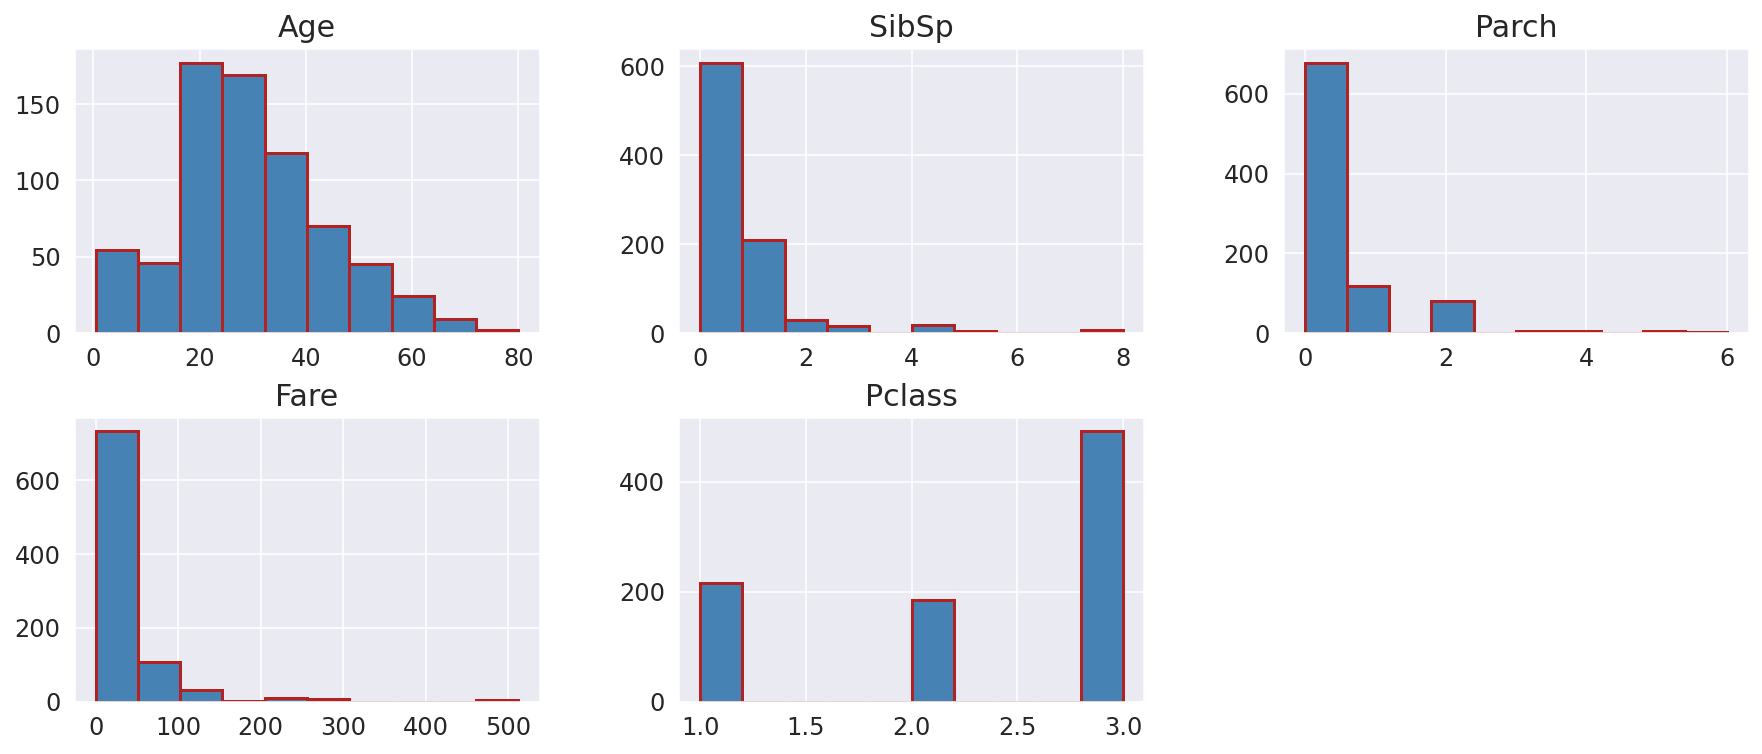

In [ ]:
num_atts = ['Age', 'SibSp', 'Parch', 'Fare', 'Pclass']
train_df[num_atts].hist(figsize = (15, 6), color = 'steelblue', edgecolor = 'firebrick', linewidth = 1.5, layout = (2, 3));

We can see that most of the passengers:

- were **young** (age < 40),
- boarded the ship **alone** (SibSp and Parch equal to 0),
- paid a **low fare** and boarded in the **3rd class**.

# Exploratory Data Analysis

Let's have a look at (almost) all attributes in greater detail.

## 1. Gender

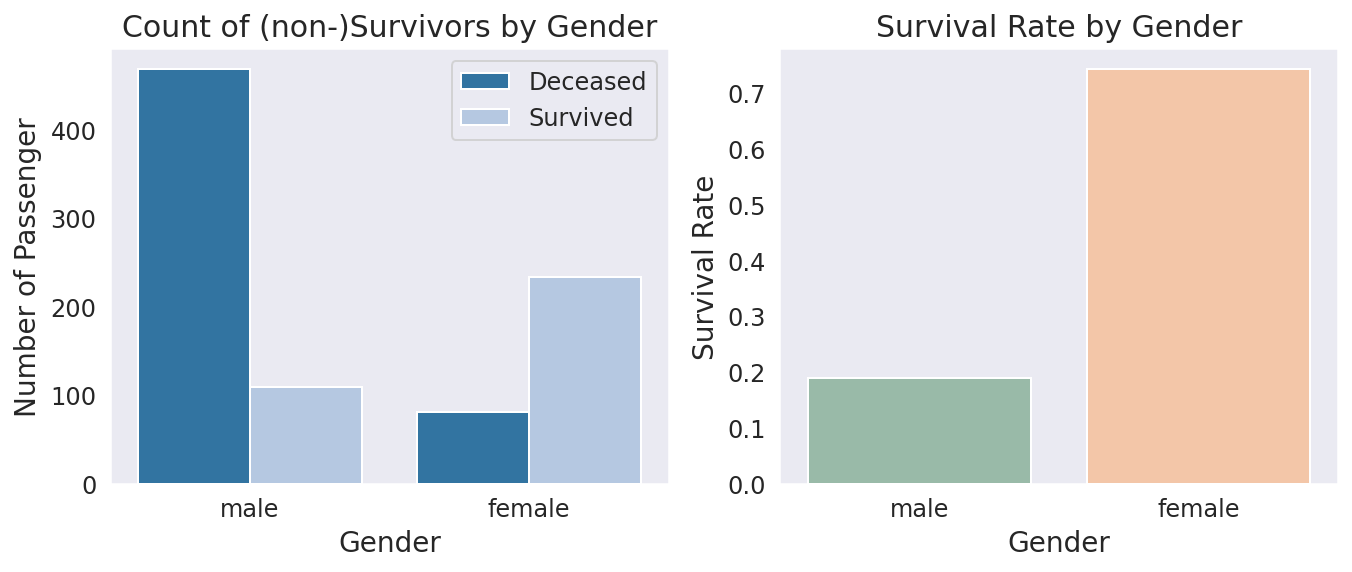

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11, 4))

sns.countplot(x = 'Sex', hue = 'Survived', data = train_df,  palette = 'tab20', ax = ax1)
ax1.set_title('Count of (non-)Survivors by Gender')
ax1.set_xlabel('Gender')
ax1.set_ylabel('Number of Passenger')
ax1.legend(labels = ['Deceased', 'Survived'])

sns.barplot(x = 'Sex', y = 'Survived', data = train_df,  palette = ['#94BFA7', '#FFC49B'], ci = None, ax = ax2)
ax2.set_title('Survival Rate by Gender')
ax2.set_xlabel('Gender')
ax2.set_ylabel('Survival Rate');

In [ ]:
# 'Sex' column과 'Survived' column간의 표를 보여준다.
pd.crosstab(train_df['Sex'], train_df['Survived'], normalize = 'index')

Survived,0,1
Sex,,
female,0.258,0.742
male,0.811,0.189


There were more men than women on board. However, **more women survived** the shipwreck (the survival rate is almost 75% for women compared to only 20% for men!).

We can read in [wikipedia](https://en.wikipedia.org/wiki/Titanic) that a "women and children first" protocol was implemented for boarding lifeboats. Therefore,  apart from women, younger people had an advantage. With that in mind, let's see the age distribution.

## 2. Age

In [ ]:
men = train_df[train_df['Sex']  == 'male']
women = train_df[train_df['Sex']  == 'female']

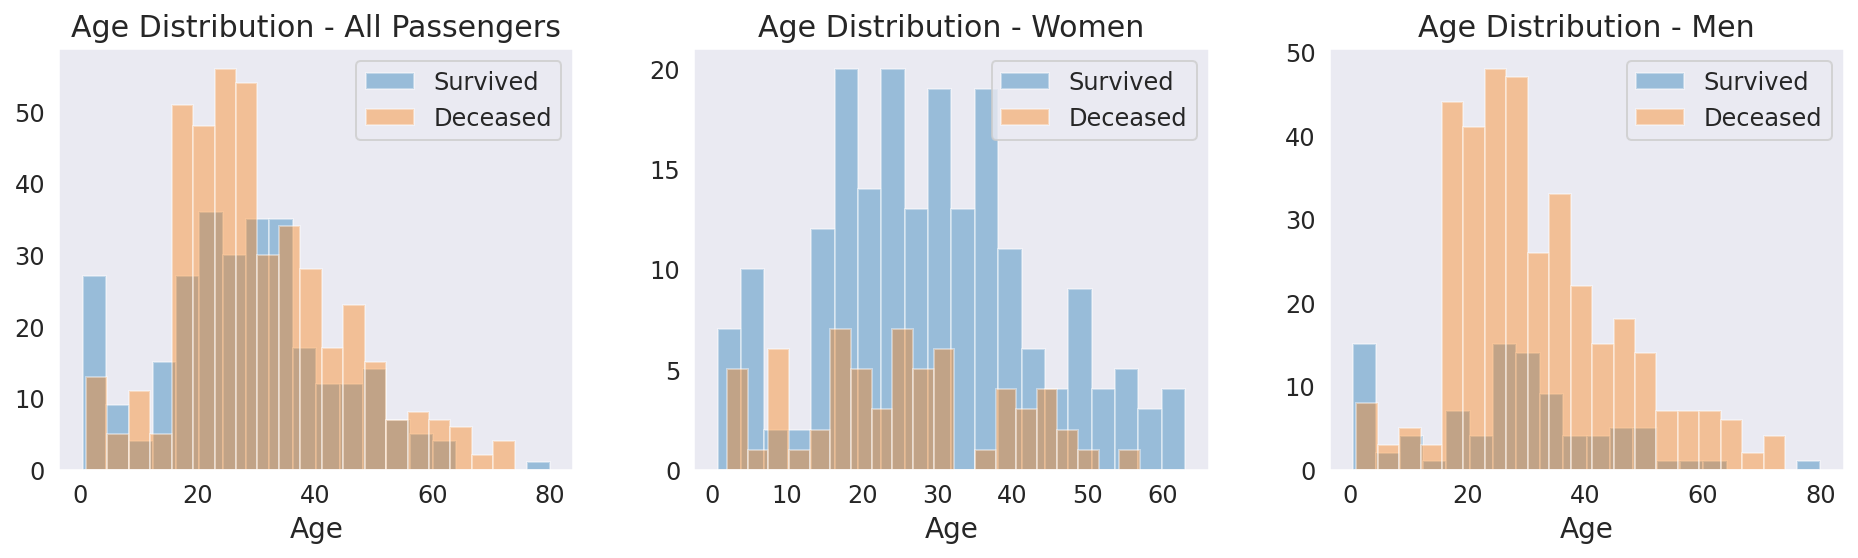

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (13, 4))

sns.distplot(train_df[train_df['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax1, kde = False)
sns.distplot(train_df[train_df['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax1, kde = False)
ax1.legend()
ax1.set_title('Age Distribution - All Passengers')

sns.distplot(women[women['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax2, kde = False)
sns.distplot(women[women['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax2, kde = False)
ax2.legend()
ax2.set_title('Age Distribution - Women')

sns.distplot(men[men['Survived'] == 1]['Age'].dropna(), bins = 20, label = 'Survived', ax = ax3, kde = False)
sns.distplot(men[men['Survived'] == 0]['Age'].dropna(), bins = 20, label = 'Deceased', ax = ax3, kde = False)
ax3.legend()
ax3.set_title('Age Distribution - Men')

plt.tight_layout();

It is evident that **different age groups** had very **different survival rates**. For instance, both genders display a higher probability of survival between the ages of 15 and 45. Also, the spike at young ages (0-4) shows that infants and young children have higher odds of survival.

Since survival seems to favour certain age groups, it might be useful to **bin** 'Age' before feeding it to an algorithm. We will pick an interval of 15 years.

In [ ]:
# train_df['Age_Bin'] = pd.qcut(train_df['Age'], 4)  # Quantile-based discretization
train_df['Age_Bin'] = (train_df['Age']//15)*15
train_df[['Age_Bin', 'Survived']].groupby(['Age_Bin']).mean()

,Survived
Age_Bin,
0.0,0.577
15.0,0.363
30.0,0.423
45.0,0.404
60.0,0.240
75.0,1.000


## 3. Port of Embarkation

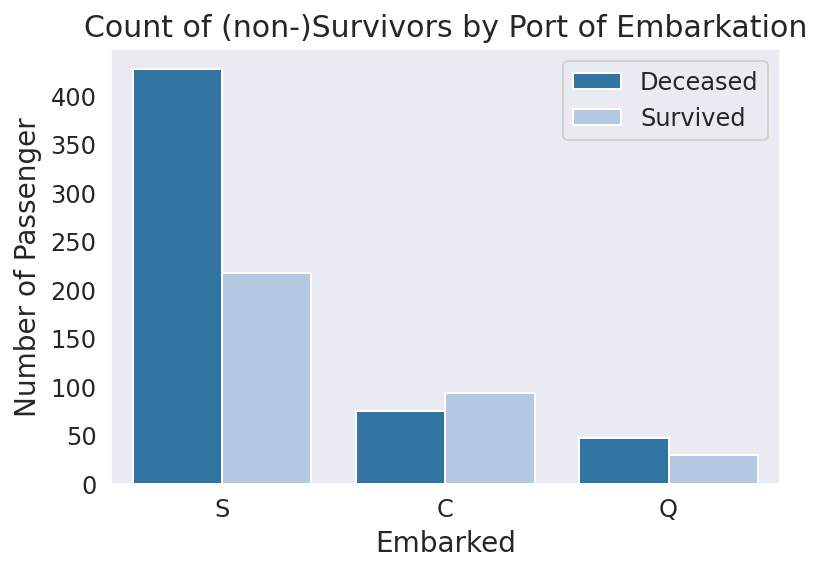

In [ ]:
sns.countplot(x = 'Embarked', hue = 'Survived', data = train_df,  palette = 'tab20')
plt.ylabel('Number of Passenger')
plt.title('Count of (non-)Survivors by Port of Embarkation')
plt.legend(['Deceased', 'Survived']);

Most passengers embarked from Southampton, the port from which the ship started its voyage. It has by far the highest count for both survivors and non-survivors. Cherbourg has the second largest number of passengers and interestingly, more than half of them survived.

Looking at the data, I wasn't confident that this attribute would be useful. After all, the ship sank at the same point and at the same time for all passengers so it doesn't really matter where they embarked. However, I decided to test it anyway and observed that the performance of my models got worse when I included it, therefore we can **ignore it**.

## 4. Pclass

In [ ]:
print ('Number of passengers in each class:')
train_df['Pclass'].value_counts()

Number of passengers in each class:


3    491
1    216
2    184
Name: Pclass, dtype: int64

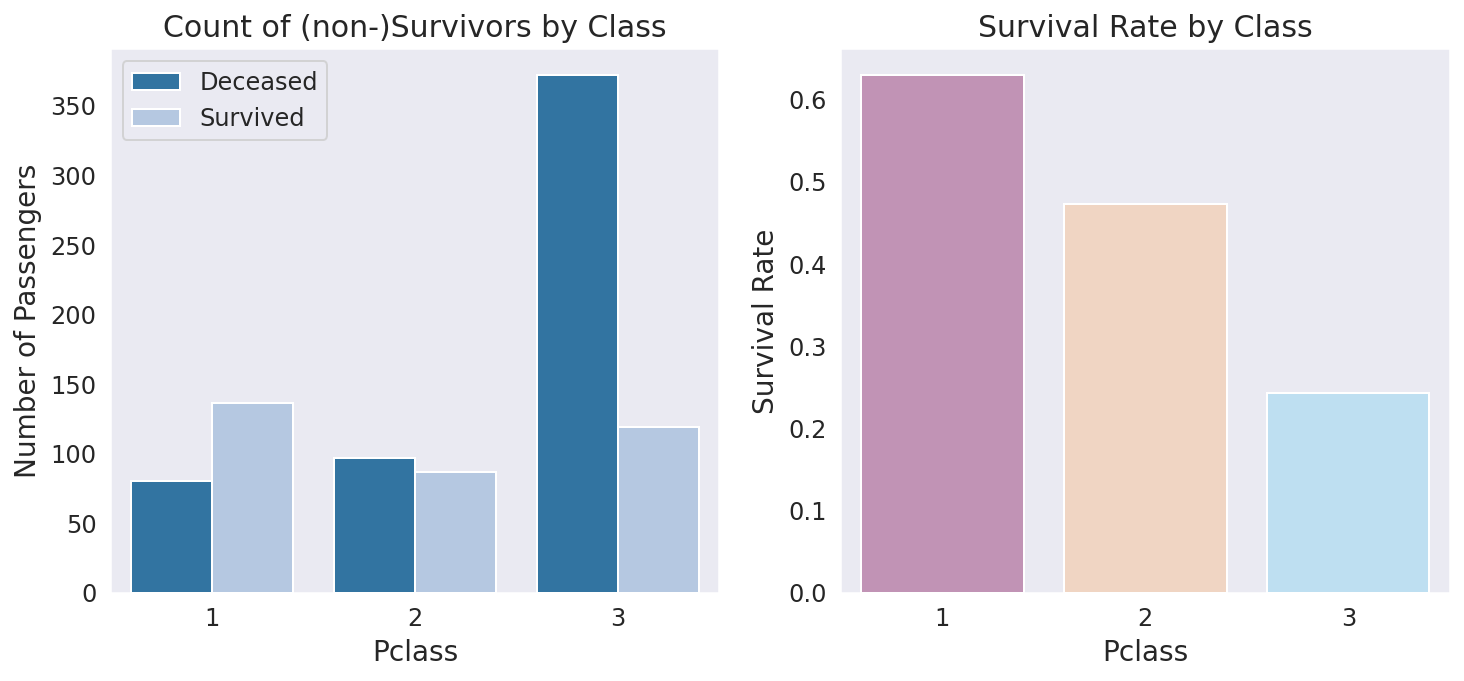

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.countplot(x = 'Pclass', hue = 'Survived', data = train_df,  palette = 'tab20', ax = ax1)
ax1.legend(['Deceased', 'Survived'])
ax1.set_title('Count of (non-)Survivors by Class')
ax1.set_ylabel('Number of Passengers')

sns.barplot(x = 'Pclass', y = 'Survived', data = train_df,  palette = ['#C98BB9', '#F7D4BC', '#B5E2FA'], ci = None, ax = ax2)
ax2.set_title('Survival Rate by Class')
ax2.set_ylabel('Survival Rate');

More than 50% of passengers boarded in the 3rd class. Nevertheless, **survival** favours the **wealthy** as shown in the right figure (the survival rate increases as we move from 3rd to 1st class).

## 5. Fare

One would assume that fare is closely related to class. Let's plot a boxplot for the distribution of Fare values across classes and a histogram for survival:

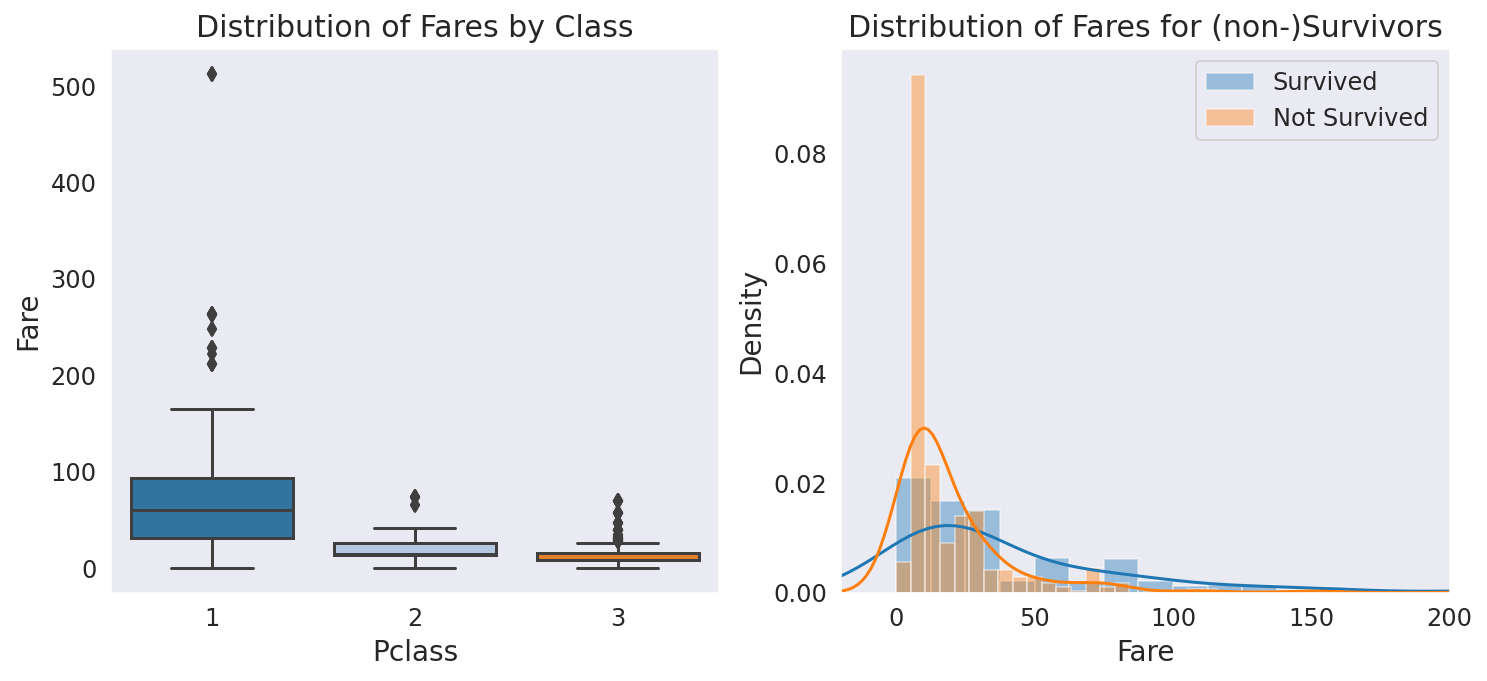

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.boxplot(x = 'Pclass', y = 'Fare', data = train_df, palette = 'tab20', ax = ax1)
ax1.set_title('Distribution of Fares by Class')

sns.distplot(train_df[train_df['Survived'] == 1]['Fare'], label = 'Survived', ax = ax2)
sns.distplot(train_df[train_df['Survived'] == 0]['Fare'], label = 'Not Survived', ax = ax2)
ax2.set_title('Distribution of Fares for (non-)Survivors')
ax2.set_xlim([-20, 200])
ax2.legend();

It's not a surprise that people in class 1 paid more than the other two classes. As we already saw in the comparison of the classes, a **higher fare** leads to a **higher chance of survival**.

As with 'Age', we can benefit from **bining** the fare value. I prefer quantile-based discretization with 5 quantiles for this attribute.

In [ ]:
train_df['Fare_Bin'] = pd.qcut(train_df['Fare'], 5)
train_df[['Fare_Bin', 'Survived']].groupby(['Fare_Bin']).mean()

,Survived
Fare_Bin,
"(-0.001, 7.854]",0.218
"(7.854, 10.5]",0.201
"(10.5, 21.679]",0.424
"(21.679, 39.688]",0.444
"(39.688, 512.329]",0.642




## 6. SibSp and Parch

Someone could argue that having relatives could influence a passenger's odds of surviving. Let's test that:

In [ ]:
alone = train_df[(train_df['SibSp'] == 0) & (train_df['Parch'] == 0)]
not_alone = train_df[(train_df['SibSp'] != 0) | (train_df['Parch'] != 0)]

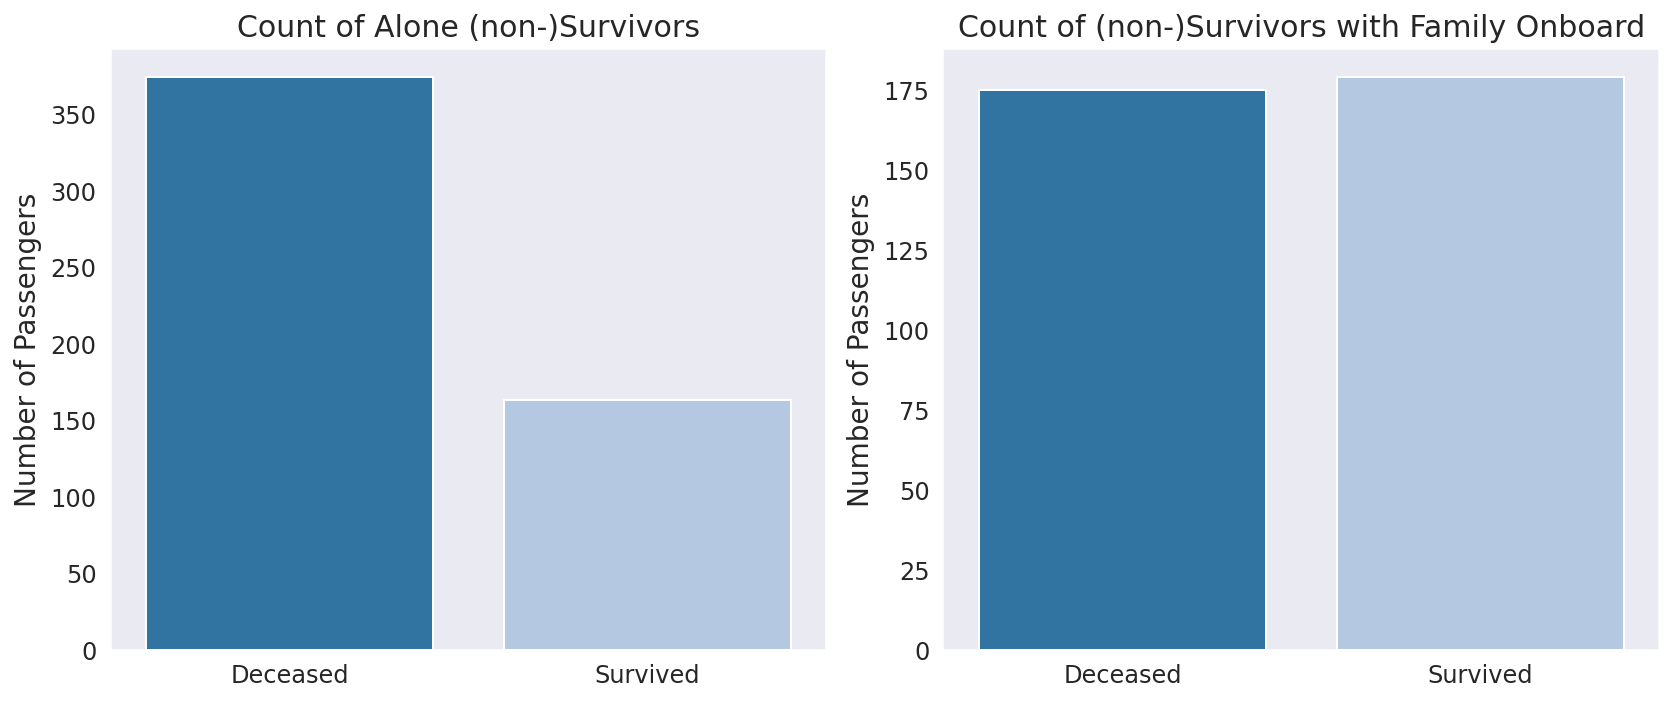

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (12, 5))

sns.countplot(x = 'Survived', data = alone,  palette = 'tab20', ax = ax1)
ax1.set_title('Count of Alone (non-)Survivors')
ax1.set_xlabel('')
ax1.set_xticklabels(['Deceased', 'Survived'])
ax1.set_ylabel('Number of Passengers')

sns.countplot(x = 'Survived', data = not_alone,  palette = 'tab20', ax = ax2)
ax2.set_title('Count of (non-)Survivors with Family Onboard')
ax2.set_xlabel('')
ax2.set_xticklabels(['Deceased', 'Survived'])
ax2.set_ylabel('Number of Passengers')

plt.tight_layout();

Having **relatives** on board **increases your chances of survival**.

Is the number of relative relevant? We can create a new attribute for the number of relatives on board and test that:

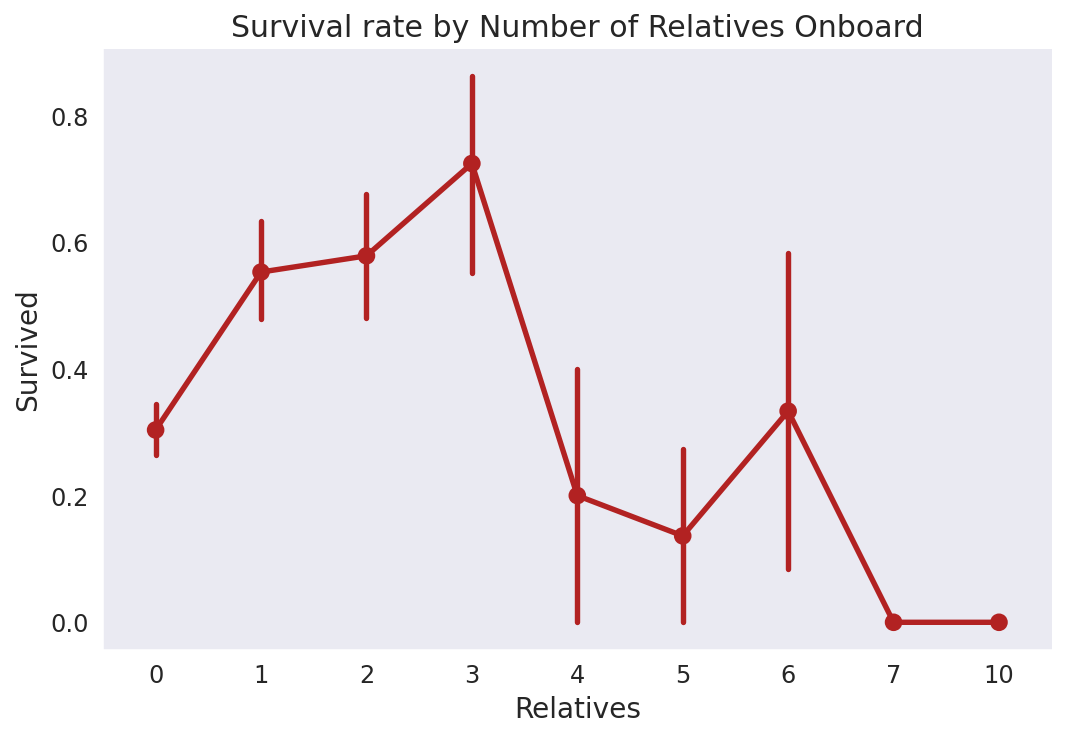

In [ ]:
train_df['Relatives'] = train_df['SibSp'] + train_df['Parch']
# train_df[['Relatives', 'Survived']].groupby(['Relatives']).mean()

sns.factorplot('Relatives', 'Survived', data = train_df, color = 'firebrick', aspect = 1.5)
plt.title('Survival rate by Number of Relatives Onboard');

Having 1 to 3 relatives can actually increase you chances of survival.

## 7. Name/Title

Finally, we could see if a person's title (Mr, Miss etc.) plays a role in survival. I used Ken's [code](https://www.kaggle.com/kenjee/titanic-project-example) to extract the title for each instance. I then replaced rare titles with more common ones.

In [22]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S


In [ ]:
train_df['Title'] = train_df['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

train_df['Title'].replace({'Mlle': 'Miss', 'Mme': 'Mrs', 'Ms': 'Miss'}, inplace = True)
train_df['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer'],
                           'Rare Title', inplace = True)
train_df['Title'].value_counts()

Mr            517
Miss          185
Mrs           126
Master         40
Rare Title     23
Name: Title, dtype: int64

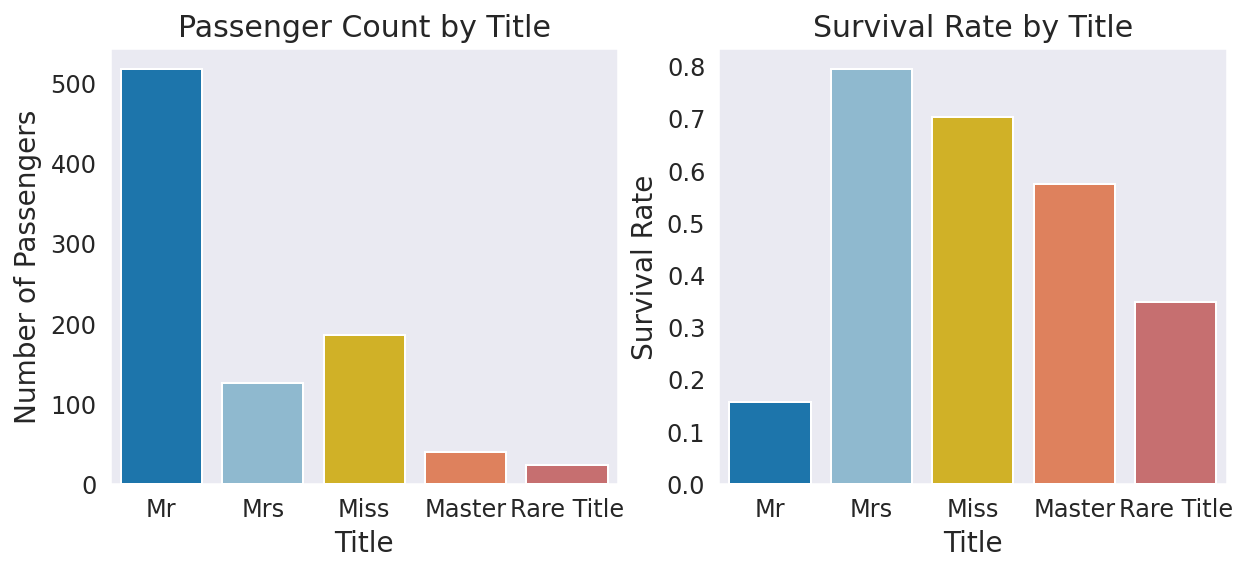

In [ ]:
cols = ['#067BC2', '#84BCDA', '#ECC30B', '#F37748', '#D56062']
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 4))

sns.countplot(x = 'Title', data = train_df,  palette = cols, ax = ax1)
ax1.set_title('Passenger Count by Title')
ax1.set_ylabel('Number of Passengers')

sns.barplot(x = 'Title', y = 'Survived', data = train_df,  palette = cols, ci = None, ax = ax2)
ax2.set_title('Survival Rate by Title')
ax2.set_ylabel('Survival Rate');

We have already talked about the fact that women (Mrs or Miss) had higher odds of survival. What's really interesting is that **Masters** and people with a **Rare Title** have indeed a **higher chance of survival** compared to 'common' men (Mr).

## 8. Others

### Cabin

As we saw earlier, 3 out of 4 instances in the training set have a missing value for 'Cabin'. Additionally, it has a large number of unique values among the existing (non-NaN) values:

In [ ]:
print ('Cabin:\n  Number of existing values: ', train_df['Cabin'].notnull().sum())
print ('    Number of unique values: ', train_df['Cabin'].nunique())

NameError: name 'train_df' is not defined

Consequently, we can safely discard it. You can have a look at this [notebook](https://www.kaggle.com/ccastleberry/titanic-cabin-features) for more information about the 'Cabin' feature.

### Ticket/Family Survival

We will indirectly use the 'Ticket' attribute to engineer a new feauture called 'Family_Survival'. The idea comes from S.Xu's [kernel](https://www.kaggle.com/shunjiangxu/blood-is-thicker-than-water-friendship-forever), in which he groups families and people with the same tickets together and searches for info based on that. A cleaner version of the code is taken from Konstantin's [kernel](https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/notebook) (see next section).

## 9. Summary


|      Attribute      | Important |            Action           |
|:-------------------:|:---------:|:---------------------------:|
|     PassengerId     |     No    |           Discard           |
|         Sex         |    Yes    |            Encode           |
|         Age         |    Yes    |        Bin and Encode       |
| Port of Embarkation |     No    |           Discard           |
|        Pclass       |    Yes    |              -              |
|         Fare        |    Yes    |        Bin and Encode       |
|   SibSp and Parch   |    Yes    |     Engineer 'Relatives'    |
|         Name        |    Yes    | Engineer 'Title' and Encode |
|        Cabin        |     No    |           Discard           |
|        Ticket       |    Yes    |  Engineer 'Family_Survival' |

# Preparing Data

In this section, we will prepare the dataframe before we build any machine learning algorithm. We will use the combined dataframe so that both the train and the test set get processed at the same time. Another alternative would be to use pipilines.

Steps:

1) Replace missing values in 'Age' and 'Fare' with the corresponding median of the train set. Note that the test set has one missing value for 'Fare' (which we can easily check by calling test_df.isnull().sum()).

In [ ]:
# 결측치를 median값으로 채운다.
all_data['Age'] = all_data['Age'].fillna(train_df['Age'].median())
all_data['Fare'] = all_data['Fare'].fillna(train_df['Fare'].median())
print ('Done!')

Done!


2) Add the new attributes ('Family_Survival', 'Age_Bin', 'Fare_Bin', 'Relatives', 'Title).

In [ ]:
# Again, the code for 'Family_Survival' comes from this kernel:
# https://www.kaggle.com/konstantinmasich/titanic-0-82-0-83/notebook

all_data['Last_Name'] = all_data['Name'].apply(lambda x: str.split(x, ',')[0])
all_data['Fare'].fillna(all_data['Fare'].mean(), inplace = True)

default_sr_value = 0.5
all_data['Family_Survival'] = default_sr_value

In [ ]:
all_data['Name']

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
413                                   Spector, Mr. Woolf
414                         Oliva y Ocana, Dona. Fermina
415                         Saether, Mr. Simon Sivertsen
416                                  Ware, Mr. Frederick
417                             Peter, Master. Michael J
Name: Name, Length: 1309, dtype: object

In [ ]:
all_data['Last_Name']

0             Braund
1            Cumings
2          Heikkinen
3           Futrelle
4              Allen
           ...      
413          Spector
414    Oliva y Ocana
415          Saether
416             Ware
417            Peter
Name: Last_Name, Length: 1309, dtype: object

In [ ]:
for grp, grp_df in all_data[['Survived','Name', 'Last_Name', 'Fare', 'Ticket', 'PassengerId', 'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Last_Name', 'Fare']):

    if (len(grp_df) != 1):  # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']

            if (smax == 1.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
            elif (smin==0.0):
                all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0



In [ ]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Family_Survival
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S,Braund,0.5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C,Cumings,0.5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Heikkinen,0.5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,Futrelle,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,Allen,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.050,NaN,S,Spector,0.5
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C,Oliva y Ocana,0.5
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S,Saether,0.5
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.050,NaN,S,Ware,0.5


In [ ]:
for _, grp_df in all_data.groupby('Ticket'):

    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            if (row['Family_Survival'] == 0) | (row['Family_Survival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']

                if (smax == 1.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 1
                elif (smin==0.0):
                    all_data.loc[all_data['PassengerId'] == passID, 'Family_Survival'] = 0

In [ ]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Family_Survival
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S,Braund,0.5
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C,Cumings,0.5
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Heikkinen,0.5
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,Futrelle,0.0
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,Allen,0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.050,NaN,S,Spector,0.5
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C,Oliva y Ocana,1.0
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S,Saether,0.5
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.050,NaN,S,Ware,0.5


In [ ]:
#####################################################################################
all_data['Age_Bin'] = (all_data['Age']//15)*15
all_data['Fare_Bin'] = pd.qcut(all_data['Fare'], 5)
all_data['Relatives'] = all_data['SibSp'] + all_data['Parch']
#####################################################################################
all_data['Title'] = all_data['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
all_data['Title'].replace({'Mlle':'Miss', 'Mme':'Mrs', 'Ms':'Miss'}, inplace = True)
all_data['Title'].replace(['Don', 'Rev', 'Dr', 'Major', 'Lady', 'Sir', 'Col', 'Capt', 'the Countess', 'Jonkheer', 'Dona'],
                           'Rare Title', inplace = True)

print ('Done!')

Done!


In [ ]:
all_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Last_Name,Family_Survival,Age_Bin,Fare_Bin,Relatives,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250,NaN,S,Braund,0.5,15.0,"(-0.001, 7.854]",1,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283,C85,C,Cumings,0.5,30.0,"(41.579, 512.329]",1,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S,Heikkinen,0.5,15.0,"(7.854, 10.5]",0,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.100,C123,S,Futrelle,0.0,30.0,"(41.579, 512.329]",1,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050,NaN,S,Allen,0.5,30.0,"(7.854, 10.5]",0,Mr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,NaN,3,"Spector, Mr. Woolf",male,28.0,0,0,A.5. 3236,8.050,NaN,S,Spector,0.5,15.0,"(7.854, 10.5]",0,Mr
414,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.900,C105,C,Oliva y Ocana,1.0,30.0,"(41.579, 512.329]",0,Rare Title
415,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.250,NaN,S,Saether,0.5,30.0,"(-0.001, 7.854]",0,Mr
416,1308,NaN,3,"Ware, Mr. Frederick",male,28.0,0,0,359309,8.050,NaN,S,Ware,0.5,15.0,"(7.854, 10.5]",0,Mr


3) Use scikit-learn's `LabelEncoder()` to encode 'Fare_Bin', 'Age_Bin', 'Title' and 'Sex'.

In [ ]:
all_data['Fare_Bin'] = LabelEncoder().fit_transform(all_data['Fare_Bin'])
all_data['Age_Bin'] = LabelEncoder().fit_transform(all_data['Age_Bin'])
all_data['Title_Bin'] = LabelEncoder().fit_transform(all_data['Title'])
all_data['Sex'] = LabelEncoder().fit_transform(all_data['Sex'])

print ('Done!')

Done!


In [ ]:
all_data['Fare_Bin']

0      0
1      4
2      1
3      4
4      1
      ..
413    1
414    4
415    0
416    1
417    3
Name: Fare_Bin, Length: 1309, dtype: int64

4) Discard all unnecessary attributes.

In [ ]:
# EDA를 한후에 예측하는데 있어서 불필요 항목 drop
all_data.drop(['PassengerId', 'Age', 'Fare', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin', 'Title', 'Last_Name', 'Embarked'], axis = 1, inplace = True)

print ('Done!')
print ('Modified dataset: ')
all_data.head()

Done!
Modified dataset: 


,Survived,Pclass,Sex,Family_Survival,Age_Bin,Fare_Bin,Relatives,Title_Bin
0,0.0,3,1,0.5,1,0,1,2
1,1.0,1,0,0.5,2,4,1,3
2,1.0,3,0,0.5,1,1,0,1
3,1.0,1,0,0.0,2,4,1,3
4,0.0,3,1,0.5,2,1,0,2


5) Split the combined dataset into train and test set and scale each feature vector.

In [ ]:
# train.csv, test.csv를 불러와서 concat한후에 다시 분리

train_df = all_data[:891]

# 학습시에 label과 학습해야할 feature를 분리
X_train = train_df.drop('Survived', 1)
y_train = train_df['Survived']

#######################################################

test_df = all_data[891:]

X_test = test_df.copy()
X_test.drop('Survived', axis = 1, inplace = True)
print ('Splitting: Done!')

Splitting: Done!


In [ ]:
std_scaler = StandardScaler()

X_train_scaled = std_scaler.fit_transform(X_train)  # fit_transform the X_train
X_test_scaled = std_scaler.transform(X_test)        # only transform the X_test

print ('Scaling: Done!')

Scaling: Done!


# Building Machine Learning Models

## Baseline Models

The aim of this subsection is to calculate the **baseline performance** of 8 different estimators/classifiers on the training set. This will enable us to later see how tuning improves each of these models.

The classifiers are:

1) Gaussian Naive Bayes , <br>
2) Logistic Regression, <br>
3) K-Nearest Neighbor Classifier, <br>
4) Support Vector Classifier, <br>
5) Decision Tree Classifier, <br>
6) Random Forest Classifier, <br>
7) Xtreme Gradient Boosting Classifier, and <br>
8) AdaBoost classifier.

I won't go into detail about how these classifiers work. You can read more in this excellent [book](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/).

For the baseline models, we will use their **default parameters** and evaluate their (mean) accuracy by performing **k-fold cross validation**.

The idea behind k-fold cross validation, which is illustrated in the following figure, is simple:
it splits the (training) set into k subsets/folds, trains the models using k-1 folds and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once.

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width = 400>
<center> Taken from the official documentation on scikit-learn's website </center>

<br>

We can implement cross validation by using the `cross_val_score()` method from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html). We will use k = 5 folds.

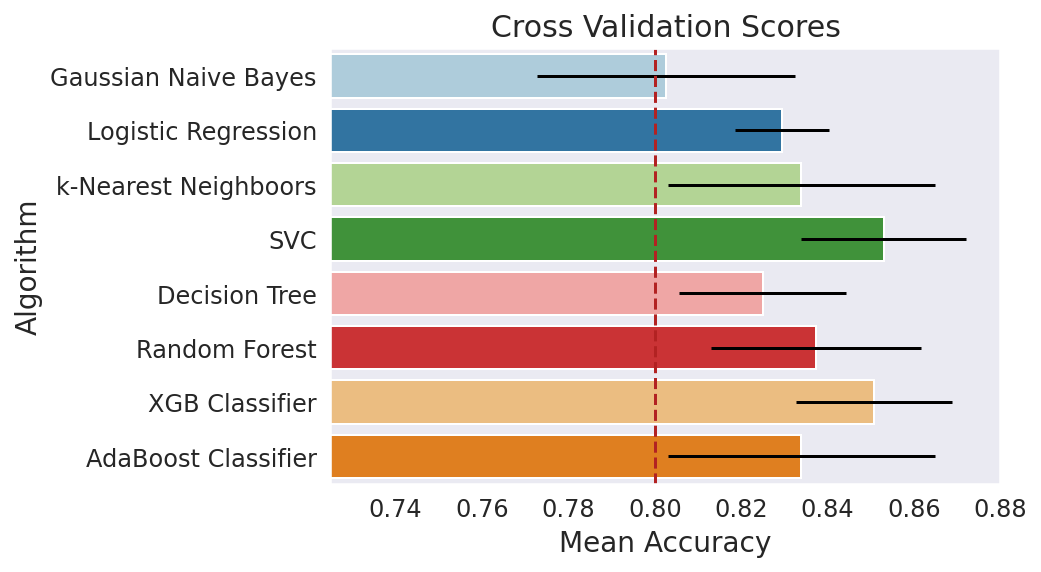

In [ ]:
random_state = 1

# Step 1: create a list containing all estimators with their default parameters
clf_list = [GaussianNB(),
            LogisticRegression(random_state = random_state),
            KNeighborsClassifier(),
            SVC(random_state = random_state, probability = True),
            DecisionTreeClassifier(random_state = random_state),
            RandomForestClassifier(random_state = random_state),
            XGBClassifier(random_state = random_state),
            AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = random_state), random_state = random_state)]


# Step 2: calculate the cv mean and standard deviation for each one of them
cv_base_mean, cv_std = [], []
for clf in clf_list:

    # 데이터셋이 크면 k-fold로 데이터를 나누는것도 시간이 오래걸릴때 cpu를 몇개를 활용할 것인가?
    # n_jobs = -1 내가 가진 cpu를 모두 활용
    cv = cross_val_score(clf, X_train_scaled, y = y_train, scoring = 'accuracy', cv = 5, n_jobs = -1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())


# Step 3: create a dataframe and plot the mean with error bars
cv_total = pd.DataFrame({'Algorithm': ['Gaussian Naive Bayes', 'Logistic Regression', 'k-Nearest Neighboors', 'SVC', 'Decision Tree', 'Random Forest', 'XGB Classifier', 'AdaBoost Classifier'],
                         'CV-Means': cv_base_mean,
                         'CV-Errors': cv_std})

sns.barplot('CV-Means', 'Algorithm', data = cv_total, palette = 'Paired', orient = 'h', **{'xerr': cv_std})
plt.xlabel('Mean Accuracy')
plt.title('Cross Validation Scores')
plt.xlim([0.725, 0.88])
plt.axvline(x = 0.80, color = 'firebrick', linestyle = '--');

All estimators have a score **above 80%**, with SVC scoring the highest (85%).

We can combine the predictions of all these base classifiers and see if we get better predictive performance compared to each constituent individual classifier. This is the main motivation behind **Ensemble Learning**.

There are two options (see [here](https://www.oreilly.com/library/view/machine-learning-for/9781783980284/47c32d8b-7b01-4696-8043-3f8472e3a447.xhtml) and [here](https://www.oreilly.com/library/view/hands-on-machine-learning/9781491962282/)):<br>
1) **Hard Voting**: A hard voting classifier counts the votes of each estimator in the ensemble and picks the class that gets the most votes. In other words, the majority wins. <br>
2) **Soft Voting**: Every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.

In [ ]:
estimators = [('gnb', clf_list[0]), ('lr', clf_list[1]),
              ('knn', clf_list[2]), ('svc', clf_list[3]),
              ('dt', clf_list[4]), ('rf', clf_list[5]),
              ('xgb', clf_list[6]), ('ada', clf_list[7])]

base_voting_hard = VotingClassifier(estimators = estimators , voting = 'hard')
base_voting_soft = VotingClassifier(estimators = estimators , voting = 'soft')

cv_hard = cross_val_score(base_voting_hard, X_train_scaled, y_train, cv = 5)
cv_soft = cross_val_score(base_voting_soft, X_train_scaled, y_train, cv = 5)

print ('Baseline Models - Ensemble\n--------------------------')
print ('Hard Voting: {}%'.format(np.round(cv_hard.mean()*100, 1)))
print ('Soft Voting: {}%'.format(np.round(cv_soft.mean()*100, 1)))

Baseline Models - Ensemble
--------------------------
Hard Voting: 84.9%
Soft Voting: 84.0%


The ensemble has indeed a higher (cv) score than most individual classifiers. We can also try dropping some classifiers and see if it improves more.

In [ ]:
base_voting_hard.fit(X_train_scaled, y_train)
base_voting_soft.fit(X_train_scaled, y_train)

y_pred_base_hard = base_voting_hard.predict(X_test_scaled)
y_pred_base_soft = base_voting_hard.predict(X_test_scaled)

## Model Tuning

We are ready to tune hyperparameters using grid search and see if performance improves. For more information about hyperparemeters, please visit the corresponding [documentation](https://scikit-learn.org/stable/).

We write a simple performance reporting function (taken from [Ken](https://www.kaggle.com/kenjee/titanic-project-example)'s kernel).

In [ ]:
cv_means_tuned = [np.nan] # we can't actually tune the GNB classifier, so we fill its element with NaN

#simple performance reporting function
def clf_performance(classifier, model_name):
    print(model_name)
    print('-------------------------------')
    print('   Best Score: ' + str(classifier.best_score_))
    print('   Best Parameters: ' + str(classifier.best_params_))

    cv_means_tuned.append(classifier.best_score_)

### Logistic Regression

In [ ]:
lr = LogisticRegression()

param_grid = {'max_iter' : [100],
              'penalty' : ['l1', 'l2'],
              'C' : np.logspace(-2, 2, 20),
              'solver' : ['lbfgs', 'liblinear']}

clf_lr = GridSearchCV(lr, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)

best_clf_lr = clf_lr.fit(X_train_scaled, y_train)
clf_performance(best_clf_lr, 'Logistic Regression')

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Logistic Regression
-------------------------------
   Best Score: 0.8361370912058252
   Best Parameters: {'C': 0.026366508987303583, 'max_iter': 100, 'penalty': 'l2', 'solver': 'lbfgs'}


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    1.0s finished


### k-Nearest Neighbors

In [ ]:
# n_neighbors = np.concatenate((np.arange(3, 30, 1), np.arange(22, 32, 2)))

knn = KNeighborsClassifier()
param_grid = {'n_neighbors' : np.arange(3, 30, 2),
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto'],
              'p': [1, 2]}

clf_knn = GridSearchCV(knn, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_knn = clf_knn.fit(X_train_scaled, y_train)
clf_performance(best_clf_knn, 'KNN')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 56 candidates, totalling 280 fits
KNN
-------------------------------
   Best Score: 0.8495888519239218
   Best Parameters: {'algorithm': 'auto', 'n_neighbors': 7, 'p': 2, 'weights': 'uniform'}


[Parallel(n_jobs=-1)]: Done 270 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 280 out of 280 | elapsed:    1.8s finished


### Support Vector Classifier

In [ ]:
svc = SVC(probability = True)
param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': [0.01, 0.1, 0.5, 1, 2, 5],
                                  'C': [.1, 1, 2, 5]},
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 2, 10]},
                                 {'kernel': ['poly'],
                                  'degree' : [2, 3, 4, 5],
                                  'C': [.1, 1, 10]}]

clf_svc = GridSearchCV(svc, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_svc = clf_svc.fit(X_train_scaled, y_train)
clf_performance(best_clf_svc, 'SVC')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    5.1s


SVC
-------------------------------
   Best Score: 0.8529470843010483
   Best Parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   11.2s finished


### Decision Tree

In [ ]:
dt = DecisionTreeClassifier(random_state = 1)
param_grid = {'max_depth': [3, 5, 10, 20, 50],
              'criterion': ['entropy', 'gini'],
              'min_samples_split': [5, 10, 15, 30],
              'max_features': [None, 'auto', 'sqrt', 'log2']}

clf_dt = GridSearchCV(dt, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_dt = clf_dt.fit(X_train_scaled, y_train)
clf_performance(best_clf_dt, 'Decision Tree')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 160 candidates, totalling 800 fits
Decision Tree
-------------------------------
   Best Score: 0.8529345301613207
   Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_split': 10}


[Parallel(n_jobs=-1)]: Done 778 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    1.5s finished


<br>

Estimators such as Random Forests, XGBoost and AdaBoost Clasiffiers allow us to see the **importance** of each feature.

### Random Forest Classifier

In [ ]:
rf = RandomForestClassifier(random_state = 42)
param_grid = {'n_estimators': [50, 150, 300, 450],
              'criterion': ['entropy'],
              'bootstrap': [True],
              'max_depth': [3, 5, 10],
              'max_features': ['auto','sqrt'],
              'min_samples_leaf': [2, 3],
              'min_samples_split': [2, 3]}

clf_rf = GridSearchCV(rf, param_grid = param_grid, cv = 5, verbose = True, n_jobs = -1)
best_clf_rf = clf_rf.fit(X_train_scaled, y_train)
clf_performance(best_clf_rf, 'Random Forest')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 206 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 456 tasks      | elapsed:  2.3min


Random Forest
-------------------------------
   Best Score: 0.8518234887954301
   Best Parameters: {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 3, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  2.5min finished


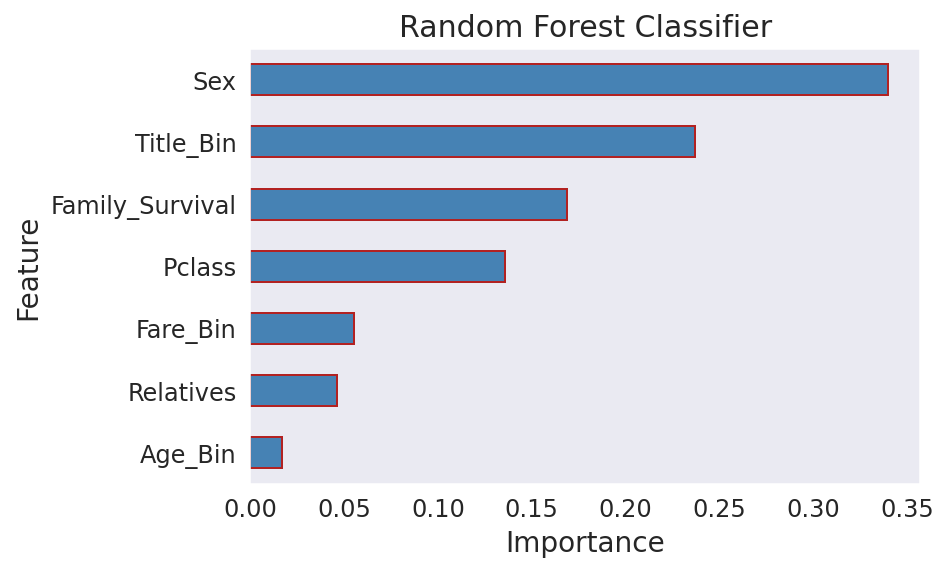

In [ ]:
best_rf = best_clf_rf.best_estimator_

importances = pd.DataFrame({'Feature': X_train.columns,
                            'Importance': np.round(best_rf.feature_importances_, 3)})

importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

importances.plot.barh(color = 'steelblue', edgecolor = 'firebrick', legend=False)
plt.title('Random Forest Classifier')
plt.xlabel('Importance');

### XGBoost Classifier

In [ ]:
xgb = XGBClassifier(random_state = 42)

param_grid = {'n_estimators': [15, 25, 50, 100],
              'colsample_bytree': [0.65, 0.75, 0.80],
              'max_depth': [5],
              'reg_alpha': [1],
              'reg_lambda': [1, 2, 5],
              'subsample': [0.50, 0.75, 1.00],
              'learning_rate': [0.01, 0.1, 0.5],
              'gamma': [0.5, 1, 2, 5],
              'min_child_weight': [0.01],
              'sampling_method': ['uniform']}

clf_xgb = GridSearchCV(xgb, param_grid = param_grid, cv = 3, verbose = True, n_jobs = -1)
best_clf_xgb = clf_xgb.fit(X_train_scaled, y_train)
clf_performance(best_clf_xgb, 'XGB')

Fitting 3 folds for each of 1296 candidates, totalling 3888 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 216 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 1416 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-1)]: Done 3416 tasks      | elapsed:  1.1min


XGB
-------------------------------
   Best Score: 0.8563411896745231
   Best Parameters: {'colsample_bytree': 0.75, 'gamma': 2, 'learning_rate': 0.01, 'max_depth': 5, 'min_child_weight': 0.01, 'n_estimators': 25, 'reg_alpha': 1, 'reg_lambda': 2, 'sampling_method': 'uniform', 'subsample': 0.75}


[Parallel(n_jobs=-1)]: Done 3888 out of 3888 | elapsed:  1.2min finished


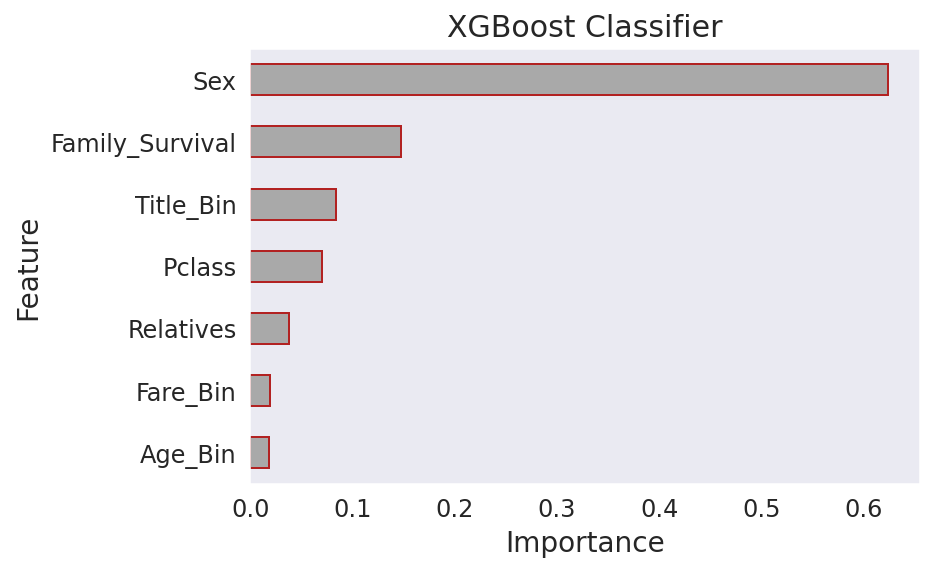

In [ ]:
best_xgb = best_clf_xgb.best_estimator_

importances = pd.DataFrame({'Feature': X_train.columns,
                            'Importance': np.round(best_xgb.feature_importances_, 3)})

importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

importances.plot.barh(color = 'darkgray', edgecolor = 'firebrick', legend = False)
plt.title('XGBoost Classifier')
plt.xlabel('Importance');

### AdaBoost

In [ ]:
adaDTC = AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = random_state), random_state=random_state)

param_grid = {'algorithm': ['SAMME', 'SAMME.R'],
              'base_estimator__criterion' : ['gini', 'entropy'],
              'base_estimator__splitter' : ['best', 'random'],
              'n_estimators': [2, 5, 10, 50],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 1, 2]}

clf_ada = GridSearchCV(adaDTC, param_grid = param_grid, cv = 5, scoring = 'accuracy', n_jobs = -1, verbose = 1)
best_clf_ada = clf_ada.fit(X_train_scaled, y_train)

clf_performance(best_clf_ada, 'AdaBost')

Fitting 5 folds for each of 192 candidates, totalling 960 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 164 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 764 tasks      | elapsed:   23.5s


AdaBost
-------------------------------
   Best Score: 0.8439834285355596
   Best Parameters: {'algorithm': 'SAMME', 'base_estimator__criterion': 'entropy', 'base_estimator__splitter': 'best', 'learning_rate': 1, 'n_estimators': 5}


[Parallel(n_jobs=-1)]: Done 960 out of 960 | elapsed:   31.1s finished


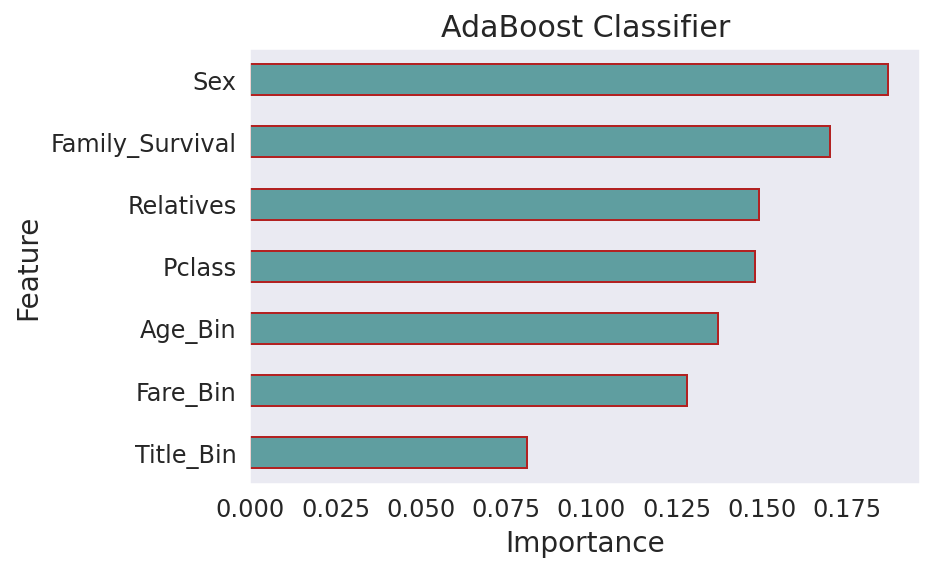

In [ ]:
best_ada = best_clf_ada.best_estimator_
importances = pd.DataFrame({'Feature': X_train.columns,
                            'Importance': np.round(best_ada.feature_importances_, 3)})

importances = importances.sort_values('Importance', ascending = True).set_index('Feature')

importances.plot.barh(color = 'cadetblue', edgecolor = 'firebrick', legend = False)
plt.title('AdaBoost Classifier')
plt.xlabel('Importance');

The results are:

In [ ]:
cv_total = pd.DataFrame({'Algorithm': ['Gaussian Naive Bayes', 'Logistic Regression', 'k-Nearest Neighboors', 'SVC', 'Decision Tree', 'Random Forest', 'XGB Classifier', 'AdaBoost Classifier'],
                         'Baseline': cv_base_mean,
                         'Tuned Performance': cv_means_tuned})

cv_total

,Algorithm,Baseline,Tuned Performance
0,Gaussian Naive Bayes,0.803,NaN
1,Logistic Regression,0.829,0.836
2,k-Nearest Neighboors,0.834,0.850
3,SVC,0.853,0.853
4,Decision Tree,0.825,0.853
5,Random Forest,0.837,0.852
6,XGB Classifier,0.851,0.856
7,AdaBoost Classifier,0.834,0.844


 We will now build the **final ensembles** 😌:

In [ ]:
best_lr = best_clf_lr.best_estimator_
best_knn = best_clf_knn.best_estimator_
best_svc = best_clf_svc.best_estimator_
best_dt = best_clf_dt.best_estimator_
best_rf = best_clf_rf.best_estimator_
best_xgb = best_clf_xgb.best_estimator_
# best_ada = best_clf_ada.best_estimator_  # didn't help me in my final ensemble

estimators = [('lr', best_lr), ('knn', best_knn), ('svc', best_svc),
              ('rf', best_rf), ('xgb', best_xgb), ('dt', best_dt)]

tuned_voting_hard = VotingClassifier(estimators = estimators, voting = 'hard', n_jobs = -1)
tuned_voting_soft = VotingClassifier(estimators = estimators, voting = 'soft', n_jobs = -1)

tuned_voting_hard.fit(X_train_scaled, y_train)
tuned_voting_soft.fit(X_train_scaled, y_train)

cv_hard = cross_val_score(tuned_voting_hard, X_train_scaled, y_train, cv = 5)
cv_soft = cross_val_score(tuned_voting_soft, X_train_scaled, y_train, cv = 5)

print ('Tuned Models - Ensemble\n-----------------------')
print ('Hard Voting: {}%'.format(np.round(cv_hard.mean()*100, 2)))
print ('Soft Voting: {}%'.format(np.round(cv_soft.mean()*100, 2)))

y_pred_tuned_hd = tuned_voting_hard.predict(X_test_scaled).astype(int)
y_pred_tuned_sf = tuned_voting_soft.predict(X_test_scaled).astype(int)

Tuned Models - Ensemble
-----------------------
Hard Voting: 85.18%
Soft Voting: 85.18%


## Submission

In [ ]:
test_df = pd.DataFrame(pd.read_csv('/content/test.csv')['PassengerId'])

pd.DataFrame(data = {'PassengerId': test_df.PassengerId,
                     'Survived': y_pred_base_hard.astype(int)}).to_csv('01-Baseline_Hard_voting.csv', index = False)

pd.DataFrame(data = {'PassengerId': test_df.PassengerId,
                     'Survived': y_pred_base_soft.astype(int)}).to_csv('02-Baseline_Soft_voting.csv', index = False)

pd.DataFrame(data = {'PassengerId': test_df.PassengerId,
                     'Survived': y_pred_tuned_hd.astype(int)}).to_csv('03-Tuned_Hard_Voting.csv', index = False)

pd.DataFrame(data = {'PassengerId': test_df.PassengerId,
                     'Survived': y_pred_tuned_sf.astype(int)}).to_csv('04-Tuned_Soft_Voting.csv', index = False)

In [ ]:
!kaggle competitions submit -c titanic -f '03-Tuned_Hard_Voting.csv' -m "03-Tuned_Hard_Voting.csv uploaded"

# Conclusions

This notebook came to an end! We can summarise it by mentioning a few points:

- **EDA** helped us understand where to **focus**. Factors such as a passenger's gender or/ and title showed that the [initial assumption](https://www.kaggle.com/c/titanic) was actually true and even though 'there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others'.
- We should not rely completely on given feautures since we could benefit from **engineering new ones**.
- Building Machine Learning models requires a lot of **tweaking** of the parameter before we get a good/optimal result. **Ensemble learning** can usually help us towards this direction.
- Lastly, I would like to mention that looking at other people's work can give us new ideas and inspiration for our own project. Just make sure you **give credit** and don't copy a whole kernel.

Feel free to ask me anything in the comment section.

Please <font size=+0 color="red"><b>upvote</b></font> if you liked this notebook! Thank you! 😉